# Here we show how to embed 3x3 periodic graphene onto Aquila and respect its geometry constriants

In [70]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
import json
import functools as ft


import numpy as np

import matplotlib.pyplot as plt
import subprocess
import copy

## Compact geometry for graphene: Open geometry

Here we will use a more compact layout for the graphene structure, which we may call "brick-wall" structure.

To see that this structure indeed make sense, we can take the slide 9 in the slides "Graph_representation", squeeze the hexagon along the y-direction to make it a square. This will give us a "brick-wall" structure. Further, we rotate the brick-wall structure by 90 degrees so that it can fit into Aquila's geometry constraint when we consider the periodic boundary condition with crossing and copy gadgets. This is shown below. 

In [44]:
def brick_wall_graphene_obc(N1, N2, ax=6e-6, ay=4e-6):
    """
    A brick wall structure for the graphene, with N1*N2 unit cells in total. Hence
    there are in total 2 * N1 * N2 variables of interest. We will use additional 
    (3N1N2-N1-N2) atoms for the negative coupling, hence there are in total (5N1N2-N1-N2)
    atoms for the brick wall structure in the open boundary condition. 
    
    ax, ay are the atom spacings along the x and y direction 
    """
    
    
    coords = []
    
    # Add the 2 * N1 * N2 variables
    for n1 in range(N1):
        for n2 in range(N2):
            cell_center_x = 2*ax * (n1 + n2)
            cell_center_y = 2*ay * (n1 - n2)
            coords.append([cell_center_x-ax, cell_center_y])
            coords.append([cell_center_x+ax, cell_center_y])
        
    # Add the auxilliary atoms
    coords_row_1 = [[n2 * ax, -n2 * ay] for n2 in range(2*N2-1)]
    coords_row_2 = [[ax + n2 * 2 * ax, ay -n2 * 2 * ay] for n2 in range(N2)]    
    for n1 in range(N1):
        coords += list(np.array(coords_row_1) + [n1*2*ax, n1*2*ay])    
        if n1 < N1-1:
            coords += list(np.array(coords_row_2) + [n1*2*ax, n1*2*ay])
    
    # Get the register based on the coordinates
    register = AtomArrangement()
    for coord in coords:
        register.add(coord)
        
    return register

def visualize_brick_wall_graphene(
    register, 
    N1, 
    N2, 
    xtick = 6e-6,
    ytick = 4e-6,
    show_atom_index=False, 
    blockade_radius: float=0.0, 
    draw_bond=True, 
    x_size=12, 
    y_size=12
):
    
    all_sites = [site.coordinate for site in register]
    
    sites_var = all_sites[:2*N1*N2]
    sites_aux = all_sites[2*N1*N2:(5*N1*N2-N1-N2)]
    sites_gadgets = all_sites[(5*N1*N2-N1-N2):]
    
    fig = plt.figure(figsize=(x_size, y_size))
    
    plt.plot(np.array(sites_var)[:, 0], np.array(sites_var)[:, 1], 'r.', ms=15, label='variables')
    plt.plot(np.array(sites_aux)[:, 0], np.array(sites_aux)[:, 1], 'b.', ms=10, label='aux. atoms')
    
    if len(sites_gadgets) > 0:
        plt.plot(np.array(sites_gadgets)[:, 0], np.array(sites_gadgets)[:, 1], 'g.', ms=10, label='gadget atoms')    
    
    if blockade_radius > 0 and draw_bond:
        for i in range(len(all_sites)):
            for j in range(i+1, len(all_sites)):            
                dist = np.linalg.norm(np.array(all_sites[i]) - np.array(all_sites[j]))
                if dist <= blockade_radius:
                    plt.plot([all_sites[i][0], all_sites[j][0]], [all_sites[i][1], all_sites[j][1]], 'k')

    if show_atom_index:
        for idx, site in enumerate(register):
            plt.text(*site.coordinate, f"  {idx}", fontsize=12)        
    
    x_min = min(graphene.coordinate_list(0))
    x_max = max(graphene.coordinate_list(0))
    y_min = min(graphene.coordinate_list(1))
    y_max = max(graphene.coordinate_list(1))
    
    plt.xticks(np.arange(x_min, x_max, xtick/3))
    plt.yticks(np.arange(y_min, y_max, ytick/2))
    
    plt.gca().set_aspect('equal')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.show()
    
    
# \sum_{ij} -1 * zi zj + \sum_i h_i zi , h>0 h_i is is the same. 
#   z0 = 1, z1 = 0  
    
#     \sum_i h_i zi = h_avg * \sum_i z_i + \sum_i (h_i-h_avg) * zi
    
    

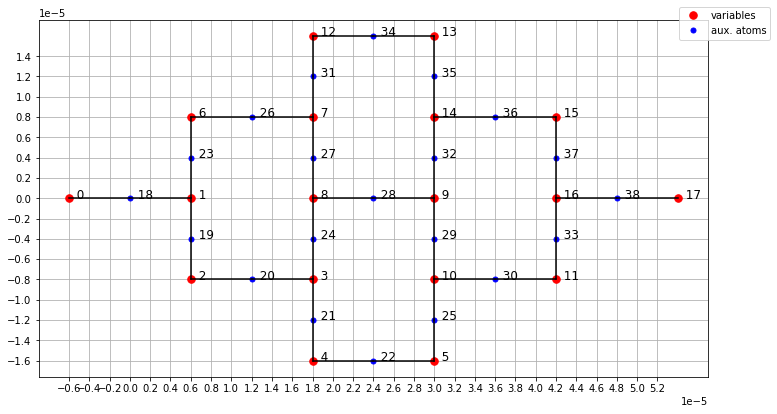

In [40]:
N1, N2 = 3, 3
blockade_radius = 6.1e-6
show_atom_index=True
graphene = brick_wall_graphene_obc(N1, N2)
visualize_brick_wall_graphene(graphene, N1, N2, blockade_radius=blockade_radius, show_atom_index=show_atom_index)

In [41]:
weights = [1 for _ in range((len(graphene)))]
# weights = [1e-3 for _ in range((len(graphene)))]
graphene_coordinate_weights = [graphene.coordinate_list(0), graphene.coordinate_list(1), weights]

with open("graphene_coordinate_weights_mwis.json", "w") as f:
    json.dump(graphene_coordinate_weights, f)
    
# subprocess.call(['julia', 'solve_graphene_mwis.jl'])

## Compact geometry for graphene: Periodic geometry

Here we can use copy and crossing gadgets to force periodic boundary condition

In [28]:
def brick_wall_graphene_pbc(N1, N2, ax=6e-6, ay=4e-6):
    """
    A brick wall structure for the graphene with periodic boundary condition
    """
    
    register = brick_wall_graphene_obc(N1, N2, ax=ax, ay=ay)
    ax2 = 2 * ax / 3 # atom separation within the crossing gadget
    ay2 = 2e-6 # For the top-most and bottom-most copy gadgets
    ax3 = 1e-6 # For the top-most and bottom-most copy gadgets
    
    # Swap the top pair of atoms and bottom pair of atoms
    def swap_top_bottom_two_vars(which):
        if which=="top":
            sign = +1
        else:
            sign = -1
    
        y1 = (N1+2) * ay * sign
        y2 = (N1+3) * ay * sign
        y3 = (N1+4) * ay * sign
        
        coords = [
            [N1*ax, y1], [(N1+2)*ax, y1], [(N1+2)*ax+ax2, y1], [(N1+2)*ax+2*ax2, y1],
            [N1*ax+ax2, y2], [N1*ax+2*ax2, y2], [N1*ax+3*ax2, y2], [N1*ax+4*ax2, y2], 
            [N1*ax+4*ax2, y3]
        ]
        
        for coord in coords:
            register.add(coord)
        
    swap_top_bottom_two_vars("top")
    swap_top_bottom_two_vars("bottom")
    
    
    # extend and swap the left-most and right most variables, along both up and down direction
    def extend_swap_left_right_most_atoms(which, where):
        if which=="left":
            coord_x = -ax
            sign_x = +1
        else:
            coord_x = 2*ax * (N1 + N2 - 2) + ax
            sign_x = -1            
            
        if where=="up":
            sign_y = +1
        else:
            sign_y = -1
            
        # Extend 
        if which=="left": # 3 atoms for the left
            coords_extend = [
                [coord_x, sign_y * ay], [coord_x, sign_y * 2*ay], [coord_x, sign_y * 3*ay]
            ]
        else:
            # We take some detour to make sure the number of atoms
            # in the copy gadget is right            
            coords_extend = [
                [coord_x, sign_y * ay], [coord_x, sign_y * 2*ay],
                [coord_x + 2e-6, sign_y * 3*ay], 
                [coord_x, sign_y * 4*ay]
            ]            

            
#         # Extend by some atoms depending on left or right. 
# #         coords_extend = [
# #             [coord_x, sign_y * ay], [coord_x, sign_y * 2*ay] # , [coord_x, sign_y * 3*ay]
# #         ]
        
#         if which=="left":
#             coords_extend.append([coord_x, sign_y * 3*ay])
#         else:
#             # We take some detour to make sure the number of atoms
#             # in the copy gadget is right
#             coords_extend.append([coord_x + ax2, sign_y * 3*ay])
#             coords_extend.append([coord_x, sign_y * 4*ay])
          
        # Swap
        coords_swap = [
            [coord_x+sign_x*ax2, sign_y * 4*ay], 
            [coord_x+sign_x*2*ax2, sign_y * 4*ay],
            [coord_x+sign_x*3*ax2, sign_y * 4*ay],
            [coord_x+sign_x*3*ax2, sign_y * 3*ay], # extension from the nearby atom to be swap
            [coord_x+sign_x*2*ax2, sign_y * 5*ay],
            [coord_x+sign_x*3*ax2, sign_y * 5*ay],
            [coord_x+sign_x*2*ax2, sign_y * 6*ay],
        ]
        
        if which=="left":
            # For the right part, we don't need to add this atom, because it is already there
            coords_swap.append(
                [coord_x+sign_x*4*ax2, sign_y * 5*ay]
            )
        
        for coord in coords_extend + coords_swap:
            register.add(coord)        

            
    extend_swap_left_right_most_atoms("left", "up")
    extend_swap_left_right_most_atoms("left", "down")
    extend_swap_left_right_most_atoms("right", "up")
    extend_swap_left_right_most_atoms("right", "down")
    
    # Connect the gadgets
    
    def connect_1(which):
        if which=="top":
            sign = +1
        else:
            sign = -1
            
        coord_x1 = 2*ax * (N1 + N2 - 2) + ax - 2*ax2
        coords_1 = [
            [coord_x1, sign * 7*ay], [coord_x1, sign * 8*ay], # [coord_x1, sign * (9*ay + ay2)],
            [(N1+2)*ax, sign * 8*ay], 
            [2 * ax, 6 * sign * ay], [2 * ax + ax2, 7 * sign * ay], [3 * ax, 8 * sign * ay],
            [4 * ax, 8 * sign * ay]
        ]
            
        coords_2 = [
#             [ax, 7 * sign * ay], [ax + ax2, 8 * sign * ay], [ax + ax2, sign * (9*ay + ay2)], 
            [ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [2 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [3 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [4 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [5 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [6 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
            [0 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)],             
            [-1 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)],                  
            [-2 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)],                
#             [-2 * ax + 1 * ax2 + ax3, sign * (9*ay + ay2)],                            
#             [-2 * ax + 0 * ax2 + ax3 - 1.5e-6, sign * (9*ay + ay2)],                 
#             [-3 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)],                    
#             [-4 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)],                                
        ]   
        
        if which == "top":
            coords_2.append([-2 * ax + 1 * ax2 + ax3 - 1.5e-6, sign * (8*ay)])
            coords_2.append([-1 * ax + 1 * ax2 + ax3 - 1.5e-6, sign * (8*ay)])            
            
            
        if which == "bottom":
            coords_2.append([-2 * ax + 0 * ax2 + ax3 - 1.5e-6 - 6e-6, sign * (9*ay + ay2)])
            coords_2.append([-2 * ax + 0 * ax2 + ax3 - 1.5e-6, sign * (9*ay + ay2)])
            coords_2.append([-2 * ax + 1 * ax2 + ax3, sign * (9*ay + ay2)])

            coords_2 += [
                [-2 * ax + 0 * ax2 + ax3 - 1.5e-6 - 6.5e-6, sign * (i*ay)] for i in range(8, -7, -1)
            ]
            
            coords_2.append([-2 * ax + 0 * ax2 + ax3 - 1.5e-6 - 4e-6, sign * (-7*ay)])
        
        for coord in coords_1 + coords_2:
            register.add(coord)           
    
    connect_1("top")
    connect_1("bottom")    
    
    
    # Add another gadge
    def add_another_gadge():
        coords = [
            [-2 * ax + 0 * ax2 + ax3 - 1.5e-6, (7*ay)],
            [-2 * ax + 0 * ax2 + ax3 - 1.5e-6, (6*ay)],
            [-2 * ax + 1 * ax2 + ax3 - 1.5e-6, (7*ay)],
            [-2 * ax + 1 * ax2 + ax3 - 1.5e-6, (6*ay)],
            [-2 * ax + 0 * ax2 + ax3 - 1.5e-6, (5*ay)],
            [-2 * ax + 2 * ax2 + ax3 - 1.5e-6 + 0.5e-6, (6*ay)],
        ]
        
        coords += [
            [-2 * ax + 0 * ax2 + ax3 - 1.5e-6, (i*ay)] for i in range(4, -7, -1)
        ]
        
        coords += [
            [-2 * ax + 0 * ax2 + ax3 - 1e-6 + 5e-6, (-6*ay)], 
            [-2 * ax + 0 * ax2 + ax3 - 1e-6 + 9e-6, (-6*ay)]
        ]
        
        for coord in coords:
            register.add(coord)           
        
        
    add_another_gadge()
    
    return register


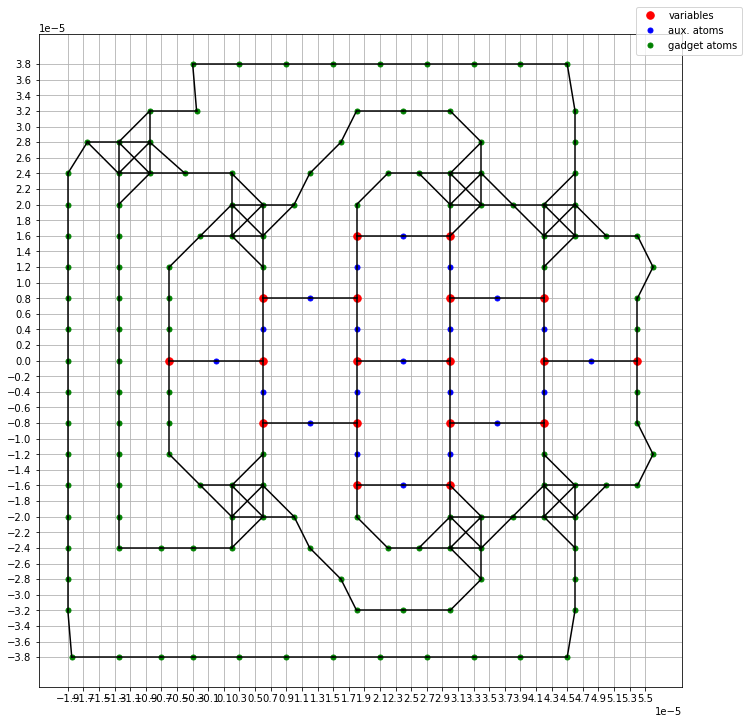

In [29]:
N1, N2 = 3, 3
blockade_radius = 6.1e-6
show_atom_index=False
graphene = brick_wall_graphene_pbc(N1, N2)
visualize_brick_wall_graphene(graphene, N1, N2, blockade_radius=blockade_radius, 
                              show_atom_index=show_atom_index, x_size = 12, y_size = 12)


## We can test that the obtained graphene structure can indeed be run on Aquila

Here we see that the whole structure is $62\mu m \times 76 \mu m$, which precisely fit in the Aquila, which support the geometry with $75\mu m \times 76 \mu m$, as of now. That is why we need to rotate the brick-wall structure. 

In [30]:
from braket.aws import AwsDevice
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=Hamiltonian(),
    register=graphene
).discretize(qpu)

task = qpu.run(ahs_program)

# If no error, that means the ahs_program is valid!
# Then we cancel the task to avoid costing money
task.cancel()

## Test 1: consider f(z) = -\sum_{ij}z_iz_j, let's see if the encoding can highlight all the red atoms

In [36]:
weights = [1 for _ in range((len(graphene)))]
# weights = [1e-3 for _ in range((len(graphene)))]
graphene_coordinate_weights = [graphene.coordinate_list(0), graphene.coordinate_list(1), weights]

with open("graphene_coordinate_weights_mwis.json", "w") as f:
    json.dump(graphene_coordinate_weights, f)
    
subprocess.call(['julia', 'solve_graphene_mwis.jl'])

0

In [37]:
with open("graphene_coordinate_weights_mwis.json", "r") as f:
    graphene_coordinate_weights_mwis = json.load(f)
mwis = graphene_coordinate_weights_mwis[-1]
mwis

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1]

In [38]:
def visualize_graphene_mwis(
    graphene, 
    mwis,
    weights,
    xtick = 6e-6,
    ytick = 4e-6,
    show_atom_index=False, 
    blockade_radius: float=0.0, 
    draw_bond=True, 
    x_size=12, 
    y_size=12    
):

    total_weights = sum(np.array(mwis) * np.array(weights))
    
    all_sites = [site.coordinate for site in graphene]
    
    fig = plt.figure(figsize=(x_size, y_size))
    
    x_list = graphene.coordinate_list(0)
    y_list = graphene.coordinate_list(1)
    
    face_colors = ['none' if item == 0 else ('red' if ind<=17 else 'blue') 
                   for ind, item in enumerate(mwis)]
    
    for ind in range(len(x_list)):
        if ind <= 17:
            edgecolor = "red"
            s = 80
        else:
            edgecolor = "blue"
            s = 40
        plt.scatter(x_list[ind], y_list[ind], s=s, 
                    facecolors=face_colors[ind], edgecolors=edgecolor)
    
    if blockade_radius > 0 and draw_bond:
        for i in range(len(all_sites)):
            for j in range(i+1, len(all_sites)):            
                dist = np.linalg.norm(np.array(all_sites[i]) - np.array(all_sites[j]))
                if dist <= blockade_radius:
                    plt.plot([all_sites[i][0], all_sites[j][0]], [all_sites[i][1], all_sites[j][1]], 'k')

    if show_atom_index:
        for idx, site in enumerate(graphene):
            plt.text(*site.coordinate, f"  {idx}", fontsize=12)        
    
    x_min = min(graphene.coordinate_list(0))
    x_max = max(graphene.coordinate_list(0))
    y_min = min(graphene.coordinate_list(1))
    y_max = max(graphene.coordinate_list(1))
    
    plt.xticks(np.arange(x_min, x_max, xtick/3))
    plt.yticks(np.arange(y_min, y_max, ytick/2))
    plt.title(f"Size and weights of MWIS = {sum(mwis)} and {total_weights} respectively")
    plt.gca().set_aspect('equal')
    plt.grid()
    plt.show()

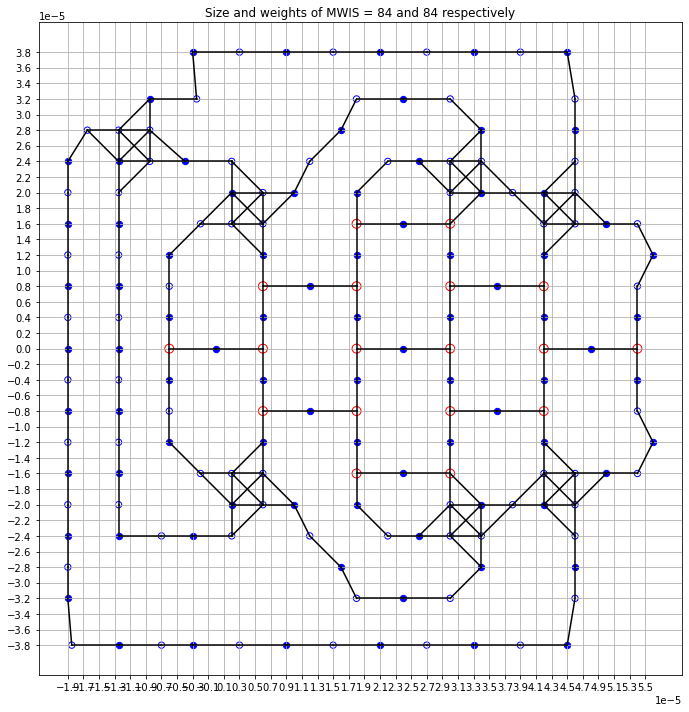

In [39]:
show_atom_index=False
visualize_graphene_mwis(graphene, mwis, weights,
                        blockade_radius=blockade_radius,
                        show_atom_index=show_atom_index,
                       )

## Test 2: More sophisticated QUBO

In [45]:
def tensor(N, indices):
    """Return the tensor product of a set of binary variables
    
    Example 1: 
        tensor(2, [0, 1]) = array([0, 0, 0, 1]) represents x0x1 with N=2 variables
    
    Example 2: 
        tensor(3, [0, 1]) = array([0, 0, 0, 0, 0, 0, 1, 1]) represents x0x1 with N=3 variables    
        
    Example 3: 
        tensor(3, [0, 2]) = array([0, 0, 0, 0, 0, 1, 0, 1]) represents x0x2 with N=3 variables    
        
    Example 4: 
        tensor(3, [1]) = array([0, 0, 1, 1, 0, 0, 1, 1]) represents x1 with N=3 variables    
        
    Example 5: 
        tensor(3, [0,1,2]) = array([0, 0, 0, 0, 0, 0, 0, 1]) represents x0x1x2 with N=3 variables    
        
    """
    
    list_binary_variables = [(1, 1) for _ in range(N)]
    for ind in indices:
        list_binary_variables[ind] = (0, 1)
        
    return ft.reduce(np.kron, list_binary_variables)

In [68]:
J = -1.0
# h = [3.1, 0, 0, 0, 3.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # 18 entries

# For OBC, the crossing is at h = 1 and ~1.187

h = [1.187 for _ in range(18)] # 18 entries 
# h = list(np.random.rand(18) * 5)
H = 0 
# Add the quadratic term
H += J * tensor(18, [0, 9])
H += J * tensor(18, [0, 10])
H += J * tensor(18, [1, 10])
H += J * tensor(18, [1, 11])
H += J * tensor(18, [2, 11])
H += J * tensor(18, [3, 9])
H += J * tensor(18, [3, 12])
H += J * tensor(18, [3, 13])
H += J * tensor(18, [4, 10])
H += J * tensor(18, [4, 13])
H += J * tensor(18, [4, 14])
H += J * tensor(18, [5, 11])
H += J * tensor(18, [5, 14])
H += J * tensor(18, [6, 12])
H += J * tensor(18, [6, 15])
H += J * tensor(18, [6, 16])
H += J * tensor(18, [7, 13])
H += J * tensor(18, [7, 17])
H += J * tensor(18, [7, 16])
H += J * tensor(18, [8, 14])
H += J * tensor(18, [8, 17])

# # Boundary conditions
# H += J * tensor(18, [0, 15])
# H += J * tensor(18, [1, 16])
# H += J * tensor(18, [2, 9])
# H += J * tensor(18, [2, 17])
# H += J * tensor(18, [5, 12])
# H += J * tensor(18, [8, 15])


# Add the linear tearm
for i in range(18):
    H += h[i] * tensor(18, [i])

min_val = min(H)
min_val_indices = [i for i in range(len(H)) if H[i]==min_val]
configs = [f'{index:018b}' for index in min_val_indices]

print(min_val, min_val_indices)
print(configs)

-5.633999999999993 [262143]
['111111111111111111']


In [74]:
J = -1.0
H = 0 
# Add the quadratic term
H += J * tensor(18, [0, 9])
H += J * tensor(18, [0, 10])
H += J * tensor(18, [1, 10])
H += J * tensor(18, [1, 11])
H += J * tensor(18, [2, 11])
H += J * tensor(18, [3, 9])
H += J * tensor(18, [3, 12])
H += J * tensor(18, [3, 13])
H += J * tensor(18, [4, 10])
H += J * tensor(18, [4, 13])
H += J * tensor(18, [4, 14])
H += J * tensor(18, [5, 11])
H += J * tensor(18, [5, 14])
H += J * tensor(18, [6, 12])
H += J * tensor(18, [6, 15])
H += J * tensor(18, [6, 16])
H += J * tensor(18, [7, 13])
H += J * tensor(18, [7, 17])
H += J * tensor(18, [7, 16])
H += J * tensor(18, [8, 14])
H += J * tensor(18, [8, 17])

# Boundary conditions
H += J * tensor(18, [0, 15])
H += J * tensor(18, [1, 16])
H += J * tensor(18, [2, 9])
H += J * tensor(18, [2, 17])
H += J * tensor(18, [5, 12])
H += J * tensor(18, [8, 15])

H2 = 0
for i in range(18):
    H2 += tensor(18, [i])

In [82]:
hrange = np.linspace(1.5, 3.0, 20)
sols = []
for h in hrange:
    H3 = H + h * H2
    min_val = min(H3)
    min_val_indices = [i for i in range(len(H3)) if H3[i]==min_val]
    configs = [f'{index:018b}' for index in min_val_indices]

    print(configs)
        

['000000000000000000', '111111111111111111']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']
['000000000000000000']


[3.101, 0.001, 0.001, 0.001, 3.101, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001

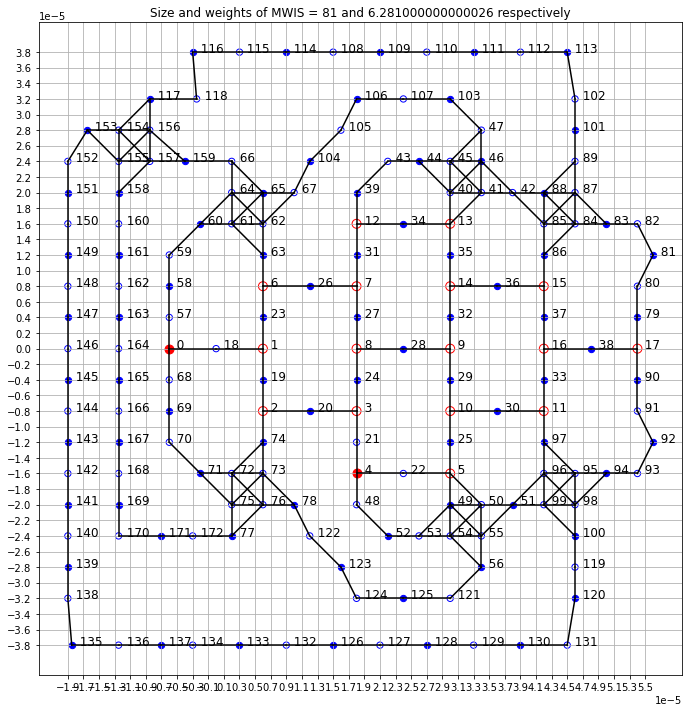

In [149]:
# weights = (max(h) + 0.0) * np.ones(len(graphene))

weights = (1e-3) * np.ones(len(graphene))
weights[:18] += h

weights = list(weights)
print(weights)

graphene_coordinate_weights = [graphene.coordinate_list(0), graphene.coordinate_list(1), weights]

with open("graphene_coordinate_weights_mwis.json", "w") as f:
    json.dump(graphene_coordinate_weights, f)
    
subprocess.call(['julia', 'solve_graphene_mwis.jl'])

with open("graphene_coordinate_weights_mwis.json", "r") as f:
    graphene_coordinate_weights_mwis = json.load(f)
mwis = graphene_coordinate_weights_mwis[-1]

show_atom_index=True
visualize_graphene_mwis(graphene, mwis, weights,
                        blockade_radius=blockade_radius,
                        show_atom_index=show_atom_index,
                       )

## Compact geometry for graphene: Periodic geometry (Old version)

Here we can use copy and crossing gadgets to force periodic boundary condition

In [9]:
# def brick_wall_graphene_pbc(N1, N2, ax=6e-6, ay=4e-6):
#     """
#     A brick wall structure for the graphene with periodic boundary condition
#     """
    
#     register = brick_wall_graphene_obc(N1, N2, ax=ax, ay=ay)
#     ax2 = 2 * ax / 3 # atom separation within the crossing gadget
#     ay2 = 2e-6 # For the top-most and bottom-most copy gadgets
#     ax3 = 1e-6 # For the top-most and bottom-most copy gadgets
    
#     # Swap the top pair of atoms and bottom pair of atoms
#     def swap_top_bottom_two_vars(which):
#         if which=="top":
#             sign = +1
#         else:
#             sign = -1
    
#         y1 = (N1+2) * ay * sign
#         y2 = (N1+3) * ay * sign
#         y3 = (N1+4) * ay * sign
        
#         coords = [
#             [N1*ax, y1], [(N1+2)*ax, y1], [(N1+2)*ax+ax2, y1], [(N1+2)*ax+2*ax2, y1],
#             [N1*ax+ax2, y2], [N1*ax+2*ax2, y2], [N1*ax+3*ax2, y2], [N1*ax+4*ax2, y2], 
#             [N1*ax+4*ax2, y3]
#         ]
        
#         for coord in coords:
#             register.add(coord)
        
#     swap_top_bottom_two_vars("top")
#     swap_top_bottom_two_vars("bottom")
    
    
#     # extend and swap the left-most and right most variables, along both up and down direction
#     def extend_swap_left_right_most_atoms(which, where):
#         if which=="left":
#             coord_x = -ax
#             sign_x = +1
#         else:
#             coord_x = 2*ax * (N1 + N2 - 2) + ax
#             sign_x = -1            
            
#         if where=="up":
#             sign_y = +1
#         else:
#             sign_y = -1
            
#         # Extend by some atoms depending on left or right. 
#         coords_extend = [
#             [coord_x, sign_y * ay], [coord_x, sign_y * 2*ay] # , [coord_x, sign_y * 3*ay]
#         ]
        
#         if which=="left":
#             coords_extend.append([coord_x, sign_y * 3*ay])
#         else:
#             # We take some detour to make sure the number of atoms
#             # in the copy gadget is right
#             coords_extend.append([coord_x + ax2, sign_y * 3*ay])
#             coords_extend.append([coord_x, sign_y * 4*ay])
          
#         # Swap
#         coords_swap = [
#             [coord_x+sign_x*ax2, sign_y * 4*ay], 
#             [coord_x+sign_x*2*ax2, sign_y * 4*ay],
#             [coord_x+sign_x*3*ax2, sign_y * 4*ay],
#             [coord_x+sign_x*3*ax2, sign_y * 3*ay], # extension from the nearby atom to be swap
#             [coord_x+sign_x*2*ax2, sign_y * 5*ay],
#             [coord_x+sign_x*3*ax2, sign_y * 5*ay],
#             [coord_x+sign_x*2*ax2, sign_y * 6*ay],
#         ]
        
#         if which=="left":
#             # For the right part, we don't need to add this atom, because it is already there
#             coords_swap.append(
#                 [coord_x+sign_x*4*ax2, sign_y * 5*ay]
#             )
        
#         for coord in coords_extend + coords_swap:
#             register.add(coord)        

            
#     extend_swap_left_right_most_atoms("left", "up")
#     extend_swap_left_right_most_atoms("left", "down")
#     extend_swap_left_right_most_atoms("right", "up")
#     extend_swap_left_right_most_atoms("right", "down")
    
#     # Connect the gadgets
    
#     def connect_1(which):
#         if which=="top":
#             sign = +1
#         else:
#             sign = -1
            
#         coord_x1 = 2*ax * (N1 + N2 - 2) + ax - 2*ax2
#         coords_1 = [
#             [coord_x1, sign * 7*ay], [coord_x1, sign * 8*ay], # [coord_x1, sign * (9*ay + ay2)],
#             [(N1+2)*ax, sign * 8*ay], 
#             [2 * ax, 6 * sign * ay], [2 * ax + ax2, 7 * sign * ay], [3 * ax, 8 * sign * ay],
#             [4 * ax, 8 * sign * ay]
#         ]
            
#         coords_2 = [
#             [ax, 7 * sign * ay], [ax + ax2, 8 * sign * ay], [ax + ax2, sign * (9*ay + ay2)], 
#             [ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#             [2 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#             [3 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#             [4 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#             [5 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#             [6 * ax + 2 * ax2 + ax3, sign * (9*ay + ay2)], 
#         ]        
            
#         for coord in coords_1 + coords_2:
#             register.add(coord)           
    
#     connect_1("top")
#     connect_1("bottom")    
    
#     return register